In [1]:
# -*- coding: utf-8 -*-

# The program will consist of three steps:
#	(1) detect edges using the Sobel’s operator,
#	(2) detect straight line segments using the Hough Transform, and
#	(3) detect parallelograms from the straight-line segments detected in step (2).
# In step (1), compute edge magnitude using the formula below and
# then normalize the magnitude values to lie within the range [0,255].
# Next, manually choose a threshold value to produce a binary edge map.

import numpy as np
import matplotlib
from matplotlib import pylab as plt
import math
import itertools as it
# import cv2
# from skimage.feature import peak_local_max
from photutils_detection_core import find_peaks
# import sys


row, col = 756, 1008  # Size of TestImage 1 and 2
# row, col = 413, 550 # Size of TestImage 3
filename = "TestImage1.raw"
T = 25  # Threshold in the normalized gradient magnitue
Canny_Edge_Detector_threshold = 10
local_maxima_window_size = 3  # neighborhood_size
# the de-Houghed image (using a relative threshold of 40%)
relative_threshold_ratio = 0.4
distance_threshold = 8  # Threshold distance to determin if a point on a line

# the least points on line to be considered to be a valid line
points_on_line_threshold = 20


In [4]:
# convert them into grayscale images by using the formula
# luminance = 0.30R + 0.59G + 0.11B,
# where R, G, and B, are the red, green, and blue components.

import scipy.ndimage as ndimage

#cvt2grayscale vectorized with Numpy - 0.019 s
def cvt2grayscale(img):
    img_size = img.size//3
    img_matrix = img.reshape((img_size,3))
    w = np.array([0.3,0.59,0.11])
    grayImage = np.dot(img_matrix,w).flatten()

    return grayImage

# Gausssion smoothing: https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm

#Built-in function - 0.027 s
def smooth_image_with_Gaussian_filter(img):
        img_copy = np.copy(img)
        img_copy = ndimage.gaussian_filter(img_copy, sigma=0.1)
        return img_copy



In [9]:
# Read Image
filepath = '../Parallelograms-Detection(Original Code)/TestImage1.raw'
testImage = np.fromfile(filepath, dtype='uint8', sep="")

# Convert to grayscale image
grayImage = cvt2grayscale(testImage).reshape([row, col])
print("Step 1: Convert image to grayscale.")
# print grayImage.shape

# Smooth_image_with_Gaussian_filter
grayImage_smoothed = smooth_image_with_Gaussian_filter(grayImage)


# Display Image
# plt.imshow(grayImage_smoothed, cmap='gray')
# plt.show()
# plt.savefig("grayImage_smoothed_with_Gaussian_filter.png")
# plt.close()


Step 1: Convert image to grayscale.


In [12]:
# Compute gradient magnitude and gradient angle
gradient_magnitude = np.zeros((row, col), dtype='uint8')
gradient_angle = np.zeros((row, col), dtype='uint8')
quantize_angle_of_the_gradient = np.zeros((row, col), dtype='uint8')


def quantize_angle_of_the_gradient_to_four_sectors(angle):
    # Double check the parameter
    if (angle < 0 or angle > 360):
        print("Warning: invalid parameter in quantize_angle_of_the_gradient_to_four_sectors(angle).")
        return 4
    if (angle <= 0 + 22.5 or
            (angle >= 180 - 22.5 and angle <= 180 + 22.5) or
            angle >= 315 + 22.5):
        return 0
    if ((angle > 45 - 22.5 and angle < 45 + 22.5) or
            (angle > 225 - 22.5 and angle < 225 + 22.5)):
        return 1
    if ((angle >= 90 - 22.5 and angle <= 90 + 22.5) or
            (angle >= 270 - 22.5 and angle <= 270 + 22.5)):
        return 2
    if ((angle > 135 - 22.5 and angle < 135 + 22.5) or
            (angle > 315 - 22.5 and angle < 315 + 22.5)):
        return 3


def compute_gradient_magnitude_and_gradient_angle(image_smoothed):
    for i in range(1, row):
        for j in range(1, col):
            Gx = (image_smoothed[i][j] + image_smoothed[i - 1][j]
                  - image_smoothed[i][j - 1] - image_smoothed[i - 1][j - 1])
            Gy = (image_smoothed[i - 1][j - 1] + image_smoothed[i - 1][j]
                  - image_smoothed[i][j - 1] - image_smoothed[i][j])
            gradient_magnitude[i][j] = math.sqrt(Gx * Gx + Gy * Gy)
            if Gx == 0:
                gradient_angle[i][j] = 90 if Gy > 0 else 270
            else:
                gradient_angle[i][j] = math.degrees(math.atan2(Gy, Gx))

            quantize_angle_of_the_gradient[i][
                j] = quantize_angle_of_the_gradient_to_four_sectors(gradient_angle[i][j])

Step 2: Canny Edge Detecter applied.


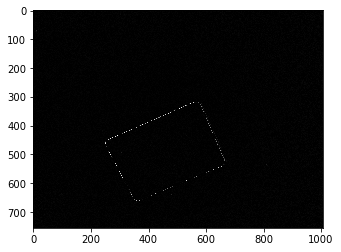

In [15]:
compute_gradient_magnitude_and_gradient_angle(grayImage_smoothed)

# Non-maxima Suppression
# 	Thin magnitude image by using a 3×3 window

#Itertools 4.871 s
prod = it.product(range(1, row - 1),range(1, col - 1))

for i,j in prod:
    sector_ij = quantize_angle_of_the_gradient[i][j]
    if sector_ij == 0:
        gradient_magnitude[i][j] = gradient_magnitude[i][j] if (gradient_magnitude[i][j] >= gradient_magnitude[i][j - 1] and gradient_magnitude[i][j] >= gradient_magnitude[i][j + 1]) else 0
    elif sector_ij == 1:
        gradient_magnitude[i][j] = gradient_magnitude[i][j] if (gradient_magnitude[i][j] >= gradient_magnitude[
                                                                i - 1][j + 1] and gradient_magnitude[i][j] >= gradient_magnitude[i + 1][j - 1]) else 0
    elif sector_ij == 2:
        gradient_magnitude[i][j] = gradient_magnitude[i][j] if (gradient_magnitude[i][j] >= gradient_magnitude[
                                                                i - 1][j] and gradient_magnitude[i][j] >= gradient_magnitude[i + 1][j]) else 0
    elif sector_ij == 3:
        gradient_magnitude[i][j] = gradient_magnitude[i][j] if (gradient_magnitude[i][j] >= gradient_magnitude[
                                                                i - 1][j - 1] and gradient_magnitude[i][j] >= gradient_magnitude[i + 1][j + 1]) else 0
    else:
        print("Warning: invalid sector in Non-maxima Suppression.")
       
for i,j in prod:
    gradient_magnitude[i][j] = gradient_magnitude[i][
        j] if gradient_magnitude[i][j] >= Canny_Edge_Detector_threshold else 0


        
print("Step 2: Canny Edge Detecter applied.")
plt.imshow(gradient_magnitude, cmap='gray')
plt.show()
# plt.savefig("edges_detected_by_Canny_Edge_Detector.png")
# plt.close()


#################################################################
#(1) detect edges using the Sobel’s operator
#– Filtering
#– Enhancement
# imgMag = sobels_operator(grayImage)
# print("Step 2: Sobel's operator applied.")
# plt.imshow(imgMag, cmap = 'gray')
# #plt.show()
# plt.savefig("edges_detected_in_image.png")
# plt.close()

imgMag = gradient_magnitude


In [16]:
#################################################################
#(2) detect straight line segments using the Hough Transform
theta_step_size = 3
p_step_size = 1
theta_MAX_VALUE = 360
p_MAX_VALUE = int(math.sqrt(row * row + col * col))
accumulator_array = np.zeros(
    (theta_MAX_VALUE // theta_step_size + 1, p_MAX_VALUE // p_step_size + 1), dtype='uint8')
# Compute the accumulator array
imgMag_row, imgMag_col = imgMag.shape
for i in range(0, imgMag_row):
    for j in range(0, imgMag_col):
        if(imgMag[i][j] > 0):
            # p = x*cos(theta) + y*sin(theta)
            theta = 0
            while theta < 360:
                theta_radians = math.radians(theta + theta_step_size / 2.0)
                p_estimate = i * math.cos(theta_radians) + \
                    j * math.sin(theta_radians)
                # Update the accumulator array
                accu_x = theta // theta_step_size
                accu_y = int(p_estimate / p_step_size)
                accumulator_array[accu_x][accu_y] += 1
                # next theta
                theta = theta + theta_step_size

max_accumulator = np.amax(accumulator_array)
print(max_accumulator)
print("Step 3: Hough Transform applied.")
# plt.imshow(accumulator_array, cmap='gray')
# plt.show()
# plt.close()



255
Step 3: Hough Transform applied.


In [ ]:



#################################################################
#(3) detect parallelograms from the straight-line segments detected in step (2).
# the de-Houghed image (using a relative threshold of 40%)
accu_row, accu_col = accumulator_array.shape
peak_list = []

# Relative threshold filtering
relative_threshold = max_accumulator * relative_threshold_ratio
for i in range(0, accu_row):
    for j in range(0, accu_col):
        # apply the threshold filter
        accumulator_i_j = accumulator_array[i][j]
        accumulator_array[i][
            j] = accumulator_i_j if accumulator_i_j >= relative_threshold else 0
        # if accumulator_i_j >= relative_threshold:
        # 	peak_p = (j + 0.5) * p_step_size
        # 	peak_theta = (i + 0.5) * theta_step_size
        # 	peak_list.append([peak_theta, peak_p])

# plt.imshow(accumulator_array, cmap='gray')
# plt.show()
# plt.close()

table = find_peaks(accumulator_array, relative_threshold)
# print(table)
peaks_found = []
for i in range(0, len(table[0])):
    table_x = table[1][i]
    table_y = table[0][i]
    peaks_found.append([(table_x + 0.5) * theta_step_size,
                        (table_y + 0.5) * p_step_size])
    # print( accumulator_array[ table_x ][ table_y ] )

print(peaks_found)


# Using local-maxima threshold
# 	With a threshold window of 3x3
window_size = local_maxima_window_size


def xy_in_range_of_accumulator_array(x, y):
    accu_arr_row, accu_arr_col = accumulator_array.shape
    return True if (x >= 0 and x < accu_arr_row and y >= 0 and y < accu_arr_col) else False


def accumulator_is_local_maxima(i, j):
    if accumulator_array[i][j] == 0:  # already surpressed
        return False
    for s_i in range((-1) * window_size, window_size + 1):
        for s_j in range((-1) * window_size, window_size + 1):
            local_x = i + s_i
            local_y = j + s_j
            if xy_in_range_of_accumulator_array(local_x, local_y):
                # Notice that there might be more than one maxima
                if accumulator_array[i][j] < accumulator_array[local_x][local_y]:
                    return False
    return True

for i in range(0, accu_row):
    for j in range(0, accu_col):
        # apply the threshold filter
        if accumulator_is_local_maxima(i, j):
            peak_p = (j + 0.5) * p_step_size
            peak_theta = (i + 0.5) * theta_step_size
            peak_list.append([peak_theta, peak_p])


# def accumulator_is_local_maxima( i, j ):
# 	if accumulator_array[i][j] == 0: # already surpressed
# 		return False
# 	for s_i in range( (-1)*window_size, window_size + 1 ):
# 		for s_j in range( (-1)*window_size, window_size + 1 ):
# 			if accumulator_array[i][j] < accumulator_array[ i + s_i ][ j + s_j ]: # Notice that there might be more than one maxima
# 				return False
# 	return True

# for i in range( window_size, accu_row - window_size):
# 	for j in range( window_size, accu_col - window_size):
# 		#apply the threshold filter
# 		if accumulator_is_local_maxima( i, j ):
# 			peak_p = (j + 0.5) * p_step_size
# 			peak_theta = (i + 0.5) * theta_step_size
# 			peak_list.append([peak_theta, peak_p])

print("peak_list: ")
print(peak_list)

peak_list = peaks_found

##########################################################################
# Filter overlaping lines
filter_step_size = theta_step_size

# Compute average of a list of int


def average_p(p_filter_list):
    list_len = len(p_filter_list)
    if list_len == 0:
        print("Warning: empty list.")
    p_sum = 0.0
    for p in p_filter_list:
        p_sum = p_sum + p

    return p_sum / list_len

# Cluster a list of int to clustered list


def cluster_list(p_list):
    p_list = sorted(p_list)
    list_len = len(p_list)
    clustered_list = []
    if list_len == 0:
        return clustered_list
    p_val = p_list[0]
    p_filter_list = []
    for i in range(0, list_len):
        if math.fabs(p_val - p_list[i]) < filter_step_size:
            p_filter_list.append(p_list[i])
        else:
            p_new_average = average_p(p_filter_list)
            clustered_list.append(p_new_average)
            # update p_val and clear p_filter_list
            p_val = p_list[i]
            p_filter_list[:] = []
            p_filter_list.append(p_list[i])

    # clear p_filter_list
    if len(p_filter_list) != 0:
        p_new_average = average_p(p_filter_list)
        clustered_list.append(p_new_average)
    return clustered_list


# Use dictionary to filter peaks
peak_dict = {}
for line in peak_list:
    if line[0] in peak_dict:
        # append the new number to the existing array at this slot
        peak_dict[line[0]].append(line[1])
    else:
        # create a new array in this slot
        peak_dict[line[0]] = [line[1]]

for key in peak_dict:
    peak_dict[key] = cluster_list(peak_dict[key])

peak_list_filtered = []
for key in peak_dict:
    for val in peak_dict[key]:
        peak_list_filtered.append([key, val])

print("peak_list_filtered: ")
print(peak_list_filtered)
peak = np.array(peak_list_filtered)

##########################################################################
# print(peak)
edge_map = np.zeros((row, col), dtype='uint8')
# Initialize to edge map to 255
for i in range(0, row):
    for j in range(0, col):
        edge_map[i][j] = 255

# Copy the magnitude array imgMag to edge_map
for i in range(0, row - 2):
    for j in range(0, col - 2):
        if imgMag[i][j] > 0:
            edge_map[i + 1][j + 1] = 0


def xy_in_range(x, y):
    return True if (x >= 0 and x < row and y >= 0 and y < col) else False


def draw_line(i_theta, i_p):
    # Draw the lines in edge_map
    i_theta_radians = math.radians(i_theta)
    if (i_theta == 0 or i_theta == 180):
        i_x = i_p / math.cos(i_theta_radians)
        for j in range(0, col):
            if xy_in_range(i_x, j):
                edge_map[i_x][j] = 0
    else:
        for i_x in range(0, row):
            i_y = int((i_p - i_x * math.cos(i_theta_radians)) /
                      math.sin(i_theta_radians))
            if xy_in_range(i_x, i_y):
                edge_map[i_x][i_y] = 0


# Draw the lines in edge_map
# print("Peak includes:")
# print( peak )
for line in peak_list_filtered:
    draw_line(line[0], line[1])
plt.imshow(edge_map, cmap="gray")
# plt.show()
plt.savefig("image_with_all_straight_lines_detected.png")
plt.close()


# sys.exit()

##########################################################################
# Extract line segments

def get_bias_key_list_in_peak_dict(key):
    bias_keys = [key]
    peak_dict_keys = peak_dict.keys()
    key1 = key
    while (key1 + theta_step_size) in peak_dict_keys:
        key1 = key1 + theta_step_size
        bias_keys.append(key1)

    key2 = key
    while (key2 - theta_step_size) in peak_dict_keys:
        key2 = key2 - theta_step_size
        bias_keys.append(key2)

    return bias_keys

# Correct bias of in Theta by allowing fluctions in theta when generating
# parallel line pairs
parallel_peak_dict = {}
for key in peak_dict:
    bias_key_list = get_bias_key_list_in_peak_dict(key)
    # Use the min_key to represent the similar keys
    min_key = min(bias_key_list)
    parallel_peak_dict[min_key] = []
    for bias_key in bias_key_list:
        bias_key_val_list = peak_dict[bias_key]
        for bias_key_val in bias_key_val_list:
            parallel_peak_dict[min_key].append((bias_key, bias_key_val))

# print("parallel_peak_dict:")
# print( parallel_peak_dict )
# Compute possible parallelogram options
para_gram_options = []
para_keys = list(it.combinations(parallel_peak_dict.keys(), 2))
for key in para_keys:
    key1, key2 = key
    key1_list = list(it.combinations(parallel_peak_dict[key1], 2))
    key2_list = list(it.combinations(parallel_peak_dict[key2], 2))
    for comb1 in key1_list:
        for comb2 in key2_list:
            theta1 = comb1[0][0]
            p1 = comb1[0][1]
            theta2 = comb1[1][0]
            p2 = comb1[1][1]
            theta3 = comb2[0][0]
            p3 = comb2[0][1]
            theta4 = comb2[1][0]
            p4 = comb2[1][1]
            para_gram_options.append(
                (theta1, p1, theta2, p2, theta3, p3, theta4, p4))

# print("para_gram_options:")
# print( para_gram_options )

# Compute valid parallelogram

# Get a copy of imgMag
mag_map_copy = np.zeros((row, col), dtype='uint8')
# Initialize to edge map to 255
for i in range(0, row):
    for j in range(0, col):
        mag_map_copy[i][j] = 255
# Copy the magnitude array imgMag to mag_map_copy
for i in range(0, row - 2):
    for j in range(0, col - 2):
        if imgMag[i][j] > 0:
            mag_map_copy[i + 1][j + 1] = 0


def sketch_dot_on_map(x, y, dot_map, sketch_val):
    dot_size = 5
    if xy_in_range(x, y):
        for i in range((-1) * dot_size, dot_size + 1):
            for j in range((-1) * dot_size, dot_size + 1):
                x_ij = i + x  # (x,y) with offset i, j
                y_ij = j + y
                if xy_in_range(x_ij, y_ij):
                    # print("sketch")
                    dot_map[int(x_ij)][int(y_ij)] = sketch_val

# Compute the intersection of two lines


def intersection(theta1, p1, theta2, p2):
    theta1_radians = math.radians(theta1)
    theta2_radians = math.radians(theta2)
    x = (p2 * math.sin(theta1_radians) - p1 * math.sin(theta2_radians)) / \
        math.sin(theta1_radians - theta2_radians)
    y = (p1 * math.cos(theta2_radians) - p2 * math.cos(theta1_radians)) / \
        math.sin(theta1_radians - theta2_radians)
    # test_sketch_dot(x,y) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return [x, y]


def get_y_from_x(i_theta, i_p, i_x):
    i_theta_radians = math.radians(i_theta)
    if (i_theta == 0 or i_theta == 180):
        return 0  # special case, but does not matter
    else:
        i_y = int((i_p - i_x * math.cos(i_theta_radians)) /
                  math.sin(i_theta_radians))
        return i_y


def near_edge_line(x, y):
    if xy_in_range(x, y):
        for i in range((-1) * distance_threshold, distance_threshold + 1):
            for j in range((-1) * distance_threshold, distance_threshold + 1):
                x_ij = i + x  # (x,y) with offset i, j
                y_ij = j + y
                if xy_in_range(x_ij, y_ij):
                    if mag_map_copy[x_ij][y_ij] == 0:
                        return True
                else:
                    continue
        return False
    else:
        return False

# Count the number of point on (theta1, p1_1) restricted by (theta2, p2_1)
# and (theta2, p2_2)


def counting_points_on_line_segment(theta1, p1, theta3, p3, theta4, p4):
    x1, y1 = intersection(theta1, p1, theta3, p3)
    x2, y2 = intersection(theta1, p1, theta4, p4)
    # test_sketch_dot(x1,y1)
    # test_sketch_dot(x2,y2)
    # plt.imshow(mag_map_copy, cmap='gray')
    # plt.show()
    # plt.close()
    # print([x1,y1,x2,y2])
    points_count = 0
    if xy_in_range(x1, y1) and xy_in_range(x2, y2):
        start_x = int(min(x1, x2))
        end_x = int(max(x1, x2))
        for x in range(start_x, end_x):
            y = get_y_from_x(theta1, p1, x)
            if near_edge_line(x, y):
                points_count = points_count + 1
        return points_count
    else:
        return 0


def draw_parallelogram(line):
    draw_line(line[0], line[1])
    draw_line(line[2], line[3])
    draw_line(line[4], line[5])
    draw_line(line[6], line[7])


def valid_parallelogram(line):
    # print("Validating parallelogram:")
    # print( line )
    # draw_parallelogram( line )
    # plt.imshow(edge_map, cmap='gray')
    # plt.show()
    # plt.close()

    if len(line) != 8:
        print("Warning: invalid data in valid_parallelogram().")
    theta1 = line[0]
    p1 = line[1]
    theta2 = line[2]
    p2 = line[3]
    theta3 = line[4]
    p3 = line[5]
    theta4 = line[6]
    p4 = line[7]
    points_line1 = counting_points_on_line_segment(
        theta1, p1, theta3, p3, theta4, p4)
    # draw_line( theta1,p1 )
    # draw_line( theta3,p3 )
    # draw_line( theta4,p4 )
    # plt.imshow(edge_map, cmap='gray')
    # plt.show()
    # plt.close()
    # print("Points on line:")
    # print( points_line1 )
    points_line2 = counting_points_on_line_segment(
        theta2, p2, theta3, p3, theta4, p4)
    points_line3 = counting_points_on_line_segment(
        theta3, p3, theta1, p1, theta2, p2)
    points_line4 = counting_points_on_line_segment(
        theta4, p4, theta1, p1, theta2, p2)

    if points_line1 > points_on_line_threshold and points_line2 > points_on_line_threshold and points_line3 > points_on_line_threshold and points_line4 > points_on_line_threshold:
        return points_line1 + points_line2 + points_line3 + points_line4
    else:  # There is no enough points on at least one line segment
        return 0

# Mask of parallelograms
# 1 is not on parallelograms, 0 is on parallelograms
mask_parallelogram = np.ones((row, col), dtype='uint8')


# add line mask from (x1,y1) to (x2,y2) on line( i_theta, i_p)
def add_line_mask(i_theta, i_p, x1, y1, x2, y2):
    x_min = int(min([x1, x2]))
    x_max = int(max([x1, x2]))
    # Draw the lines in mask
    i_theta_radians = math.radians(i_theta)
    if (i_theta == 0 or i_theta == 180):  # x1 == x2
        y_min = int(min([y1, y2]))
        y_max = int(max([y1, y2]))
        i_x = x_min
        for j in range(y_min, y_max + 1):
            if xy_in_range(i_x, j):
                mask_parallelogram[i_x][j] = 0
    else:
        for i_x in range(x_min, x_max):
            i_y = int((i_p - i_x * math.cos(i_theta_radians)) /
                      math.sin(i_theta_radians))
            if xy_in_range(i_x, i_y):
                mask_parallelogram[i_x][i_y] = 0


def add_parallelogram_mask(line):
    theta1 = line[0]
    p1 = line[1]
    theta2 = line[2]
    p2 = line[3]
    theta3 = line[4]
    p3 = line[5]
    theta4 = line[6]
    p4 = line[7]
    x1, y1 = intersection(theta1, p1, theta3, p3)
    x2, y2 = intersection(theta2, p2, theta3, p3)
    x3, y3 = intersection(theta2, p2, theta4, p4)
    x4, y4 = intersection(theta1, p1, theta4, p4)
    add_line_mask(theta3, p3, x1, y1, x2, y2)
    add_line_mask(theta2, p3, x2, y2, x3, y3)
    add_line_mask(theta4, p4, x3, y3, x4, y4)
    add_line_mask(theta1, p1, x4, y4, x1, y1)
    # Sketch on end points
    sketch_dot_on_map(x1, y1, mask_parallelogram, 0)
    sketch_dot_on_map(x2, y2, mask_parallelogram, 0)
    sketch_dot_on_map(x3, y3, mask_parallelogram, 0)
    sketch_dot_on_map(x4, y4, mask_parallelogram, 0)
    # Print end points
    print([x1, y1, x2, y2, x3, y3, x4, y4])


valid_parallelogram_list = []
points_on_parallelogram = []
print("Length of para_gram_options:")
print(len(para_gram_options))
for line in para_gram_options:
    points_on_line = valid_parallelogram(line)
    points_on_parallelogram.append(points_on_line)
    if points_on_line > 0:
        #draw_parallelogram( line )
        add_parallelogram_mask(line)
        # plt.imshow(edge_map, cmap='gray')
        # plt.show()
        # plt.close()

    #	valid_parallelogram_list.append( line )

# print("Points_on_parallelogram = ")
# print( points_on_parallelogram )

# Use the mask
masked_image_list = []
for i in range(0, row):
    for j in range(0, col):
        # Use the mask
        masked_image_list.append(grayImage[i][j] * mask_parallelogram[i][j])
        # masked_image_list.append( testImage[ i*col + j*3 + 0 ] * mask_parallelogram[i][j] )
        # masked_image_list.append( testImage[ i*col + j*3 + 1 ] * mask_parallelogram[i][j] )
        # masked_image_list.append( testImage[ i*col + j*3 + 2 ] * mask_parallelogram[i][j] )


maskedImage = np.array(masked_image_list).reshape([row, col])

# plt.imshow(maskedImage, cmap = "gray")
# #plt.show()
# plt.savefig("maskedImage.png")
# plt.close()
matplotlib.image.imsave('maskedImage.png', maskedImage)


# Saving filtered image to new file
